# Работа 4. VI.9.29 — экстраполяция численности населения

Даны наблюдения **год → численность населения**.  
Мы используем 2025 как референс и используем данные **до 2020 включительно**, чтобы предсказать население в 2025, а затем сравнить с эталоном.

**Методы:**
1. Классическая полиномиальная интерполяция по Ньютону (разделённые разности).
2. Сплайн-интерполяция.
   коэффициенты сплайна находим через собственную реализацию **трёхдиагональной прогонки**.
3. Метод наименьших квадратов.

## 0. Исходные данные


In [ ]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

switzerland_population = [
    (1910,  3898000),
    (1920,  3880000),
    (1930,  4047000),
    (1940,  4280000),
    (1950,  4710000),
    (1960,  5300000),
    (1970,  6190000),
    (1980,  6390000),
    (1990,  6920000),
    (2000,  7230000),
    (2010,  7900000),
    (2020,  8715000),
    (2025,  9050000),
]

df = pd.DataFrame(switzerland_population, columns=["year", "population"])
df

,year,population
0,1910,3898000
1,1920,3880000
2,1930,4047000
3,1940,4280000
4,1950,4710000
5,1960,5300000
6,1970,6190000
7,1980,6390000
8,1990,6920000
9,2000,7230000


In [10]:
year_target = 2025
train = df[df["year"] <= 2020].copy()
ref = df[df["year"] == year_target].copy()

x_train = train["year"].to_numpy(dtype=float)
y_train = train["population"].to_numpy(dtype=float)

y_ref = float(ref["population"].iloc[0])

def fmt_pop(v):
    return f"{int(round(float(v))):,}"

print("Точек в обучении:", len(x_train), f"({int(x_train.min())}..{int(x_train.max())})")
print("Эталон:", year_target, "→", fmt_pop(y_ref))

Точек в обучении: 12 (1910..2020)
Эталон: 2025 → 9,050,000


Если работать с годами напрямую (1910, 1920, ...), в полиномах степени 5–10 числа становятся очень большими.

Поэтому вводим преобразование:
$$
t = \frac{x - x_c}{s},
$$
где $x_c$ — центр, $s$ — масштаб (например 10 лет).

Дальше все полиномиальные методы будем строить по $t$, а не по $x$.

In [11]:
x_center = float(x_train[0])
scale = 10.0

t_train = (x_train - x_center) / scale
t_target = (year_target - x_center) / scale

print("x_center =", int(x_center), "scale =", scale)
print("t_target =", t_target)

x_center = 1910 scale = 10.0
t_target = 11.5


## 1) Полиномиальная интерполяция по Ньютону

построим полином $P(t)$, который проходит через все обучающие точки:
$$
P(t_i)=y_i.
$$

В форме Ньютона:
$$
P(t)=a_0 + a_1(t-t_0) + a_2(t-t_0)(t-t_1)+\dots
$$

Коэффициенты $a_k$ находим через **разделённые разности**.

In [ ]:
def newton_coeffs(tt, yy):
    n = len(tt)
    a = [float(v) for v in yy]
    t = [float(v) for v in tt]

    for k in range(1, n):
        for i in range(n - 1, k - 1, -1):
            denom = t[i] - t[i - k]
            a[i] = (a[i] - a[i - 1]) / denom
    return a

def newton_value(tt, a, tq):
    t = [float(v) for v in tt]
    p = float(a[-1])
    for k in range(len(t) - 2, -1, -1):
        p = p * (tq - t[k]) + float(a[k])
    return p

aN = newton_coeffs(t_train, y_train)
pred_newton = newton_value(t_train, aN, t_target)
, 123202624), (1940, 132164569), 
print("Ньютон: прогноз на 2025 =", fmt_pop(pred_newton))
print("Абс. ошибка =", fmt_pop(abs(pred_newton - y_ref)))
print("Отн. ошибка =", abs(pred_newton - y_ref) / y_ref)

Ньютон: прогноз на 2025 = -50,648,099
Абс. ошибка = 59,698,099
Отн. ошибка = 6.5964750789410616


## 2) Натуральный кубический сплайн

Кубический сплайн — это кусочно-кубическая функция, которая на каждом промежутке $[x_i, x_{i+1}]$ является кубическим полиномом;

Для натурального сплайна:
$$
S''(x_0)=0,\quad S''(x_n)=0.
$$

Здесь мы будем искать значения вторых производных в узлах:
$$
M_i = S''(x_i).
$$

Они находятся из трёхдиагональной системы — поэтому нужен метод прогонки.

In [13]:
def thomas_tridiagonal(lower, diag, upper, rhs):
    # Решает трёхдиагональную систему методом прогонки (Томаса)
    n = len(diag)

    c_star = [0.0] * n
    d_star = [0.0] * n

    c_star[0] = upper[0] / diag[0]
    d_star[0] = rhs[0] / diag[0]

    for i in range(1, n):
        denom = diag[i] - lower[i - 1] * c_star[i - 1]
        if i < n - 1:
            c_star[i] = upper[i] / denom
        d_star[i] = (rhs[i] - lower[i - 1] * d_star[i - 1]) / denom

    x = [0.0] * n
    x[-1] = d_star[-1]
    for i in range(n - 2, -1, -1):
        x[i] = d_star[i] - c_star[i] * x[i + 1]

    return x

def spline_moments_natural(x, y):
    x = [float(v) for v in x]
    y = [float(v) for v in y]
    n = len(x)

    M = [0.0] * n
    if n <= 2:
        return M

    h = [x[i+1] - x[i] for i in range(n - 1)]

    # система для внутренних M_1..M_{n-2}
    m = n - 2
    lower = [0.0] * (m - 1)
    diag  = [0.0] * m
    upper = [0.0] * (m - 1)
    rhs   = [0.0] * m

    for i in range(1, n - 1):
        hi_1 = h[i - 1]
        hi = h[i]
        row = i - 1

        diag[row] = 2.0 * (hi_1 + hi)
        if row - 1 >= 0:
            lower[row - 1] = hi_1
        if row + 1 <= m - 1:
            upper[row] = hi

        slope_r = (y[i+1] - y[i]) / hi
        slope_l = (y[i] - y[i-1]) / hi_1
        rhs[row] = 6.0 * (slope_r - slope_l)

    sol = thomas_tridiagonal(lower, diag, upper, rhs)
    for i in range(m):
        M[i + 1] = sol[i]
    return M

def spline_eval_natural(x, y, M, xq):
    # допускаем xq вне диапазона: используем крайний интервал (экстраполяция концом)
    x = [float(v) for v in x]
    y = [float(v) for v in y]
    M = [float(v) for v in M]
    xq = float(xq)

    n = len(x)
    if xq <= x[0]:
        i = 0
    elif xq >= x[-1]:
        i = n - 2
    else:
        i = 0
        while i < n - 1 and not (x[i] <= xq <= x[i+1]):
            i += 1
        if i == n - 1:
            i = n - 2

    x0, x1 = x[i], x[i+1]
    y0, y1 = y[i], y[i+1]
    M0, M1 = M[i], M[i+1]
    h = x1 - x0

    A = (x1 - xq) / h
    B = (xq - x0) / h

    term1 = (M0 * (A**3) + M1 * (B**3)) * (h**2) / 6.0
    term2 = (y0 - M0 * h**2 / 6.0) * A + (y1 - M1 * h**2 / 6.0) * B
    return term1 + term2

M_nat = spline_moments_natural(x_train, y_train)
pred_spline = spline_eval_natural(x_train, y_train, M_nat, year_target)

print("Сплайн: прогноз на 2025 =", fmt_pop(pred_spline))
print("Абс. ошибка =", fmt_pop(abs(pred_spline - y_ref)))
print("Отн. ошибка =", abs(pred_spline - y_ref) / y_ref)

Сплайн: прогноз на 2025 = 9,124,757
Абс. ошибка = 74,757
Отн. ошибка = 0.008260459494747591


## 3) Метод наименьших квадратов

Вместо того чтобы проходить через все точки, подбираем полином степени $d$ так, чтобы минимизировать сумму квадратов ошибок:
$$
\min_c \sum_{i=1}^n (P_d(t_i)-y_i)^2.
$$

Построим матрицу Вандермонда $V$ и решим нормальные уравнения:
$$
(V^T V)c = V^T y.
$$

Решение СЛАУ сделаем своим методом Гаусса (с частичным выбором ведущего элемента), без `np.linalg.lstsq`.

In [14]:
def gauss_solve_pivot(A, b):
    # Решает Ax=b (A квадратная) методом Гаусса с частичным выбором
    n = len(A)
    M = [row[:] + [float(bi)] for row, bi in zip([[float(v) for v in r] for r in A], b)]

    for k in range(n):
        piv = k
        best = abs(M[k][k])
        for i in range(k + 1, n):
            val = abs(M[i][k])
            if val > best:
                best = val
                piv = i
        if best == 0.0:
            return None

        if piv != k:
            M[k], M[piv] = M[piv], M[k]

        pivot = M[k][k]
        for i in range(k + 1, n):
            factor = M[i][k] / pivot
            if factor == 0.0:
                continue
            for j in range(k, n + 1):
                M[i][j] -= factor * M[k][j]

    x = [0.0] * n
    for i in range(n - 1, -1, -1):
        s = M[i][n]
        for j in range(i + 1, n):
            s -= M[i][j] * x[j]
        if M[i][i] == 0.0:
            return None
        x[i] = s / M[i][i]
    return x

def vandermonde_rows(t, deg):
    # строим V, где V[i][k] = t_i^k (k=0..deg)
    V = []
    for ti in t:
        row = [1.0]
        for k in range(1, deg + 1):
            row.append(row[-1] * float(ti))
        V.append(row)
    return V

def normal_equations(V, y):
    n = len(V)
    m = len(V[0])

    G = [[0.0] * m for _ in range(m)]
    g = [0.0] * m

    for i in range(n):
        vi = V[i]
        yi = float(y[i])
        for p in range(m):
            g[p] += vi[p] * yi
            for q in range(m):
                G[p][q] += vi[p] * vi[q]
    return G, g

def poly_eval_horner(c, t):
    # c[0] + c[1] t + ... (обычный Горнер)
    t = float(t)
    acc = float(c[-1])
    for k in range(len(c) - 2, -1, -1):
        acc = acc * t + float(c[k])
    return acc

def poly_predict_ls(t_train, y_train, deg, t_query):
    V = vandermonde_rows(t_train, deg)
    G, g = normal_equations(V, y_train)
    c = gauss_solve_pivot(G, g)
    if c is None:
        return None, None
    return c, poly_eval_horner(c, t_query)

def rmse(t_train, y_train, coeffs):
    se = 0.0
    for ti, yi in zip(t_train, y_train):
        yi_hat = poly_eval_horner(coeffs, ti)
        se += (yi_hat - yi) ** 2
    return math.sqrt(se / len(t_train))

deg_candidates = list(range(1, 7))
rows = []

for d in deg_candidates:
    coeffs, pred = poly_predict_ls(t_train, y_train, d, t_target)
    if coeffs is None:
        continue
    rows.append({
        "степень": d,
        "прогноз_2025": pred,
        "абс_ошибка": abs(pred - y_ref),
        "отн_ошибка": abs(pred - y_ref) / y_ref,
        "RMSE_на_обучении": rmse(t_train, y_train, coeffs),
        "коэфф": coeffs,
    })

ls_df = pd.DataFrame(rows).sort_values(["абс_ошибка", "степень"]).reset_index(drop=True)

show = ls_df.drop(columns=["коэфф"]).copy()
show["прогноз_2025"] = show["прогноз_2025"].map(fmt_pop)
show["абс_ошибка"] = show["абс_ошибка"].map(fmt_pop)
show["отн_ошибка"] = show["отн_ошибка"].map(lambda z: f"{z:.6f}")
show["RMSE_на_обучении"] = show["RMSE_на_обучении"].map(lambda z: fmt_pop(z))
show

,степень,прогноз_2025,абс_ошибка,отн_ошибка,RMSE_на_обучении
0,2,"9,039,244","10,756",0.001188,"187,030"
1,4,"9,177,676","127,676",0.014108,"112,170"
2,6,"9,277,407","227,407",0.025128,"79,614"
3,3,"8,763,131","286,869",0.031698,"159,952"
4,5,"9,535,018","485,018",0.053593,"86,401"
5,1,"8,527,732","522,268",0.057709,"291,810"


## Сводная таблица результатов (прогноз на 2025)

Соберём прогнозы трёх подходов и сравним с эталоном.

In [15]:
best_ls = ls_df.iloc[0]
pred_ls = float(best_ls["прогноз_2025"])
best_deg = int(best_ls["степень"])

summary = pd.DataFrame([
    {"Метод": "Ньютон (интерполяция)", "Прогноз 2025": pred_newton},
    {"Метод": "Кубический сплайн", "Прогноз 2025": pred_spline},
    {"Метод": f"МНК полином (степень {best_deg})", "Прогноз 2025": pred_ls},
    {"Метод": "Эталон", "Прогноз 2025": y_ref},
])

summary["Абс. ошибка"] = (summary["Прогноз 2025"] - y_ref).abs()
summary["Отн. ошибка"] = summary["Абс. ошибка"] / y_ref

view = summary.copy()
view["Прогноз 2025"] = view["Прогноз 2025"].map(fmt_pop)
view["Абс. ошибка"] = view["Абс. ошибка"].map(fmt_pop)
view["Отн. ошибка"] = view["Отн. ошибка"].map(lambda z: f"{z:.6f}")
view

,Метод,Прогноз 2025,Абс. ошибка,Отн. ошибка
0,Ньютон (интерполяция),"-50,648,099","59,698,099",6.596475
1,Кубический сплайн,"9,124,757","74,757",0.008260
2,МНК полином (степень 2),"9,039,244","10,756",0.001188
3,Эталон,"9,050,000",0,0.000000


## График: точки и аппроксимации

Построим:
- обучающие точки до 2020,
- эталонную точку 2025,
- кривые трёх методов на сетке лет.

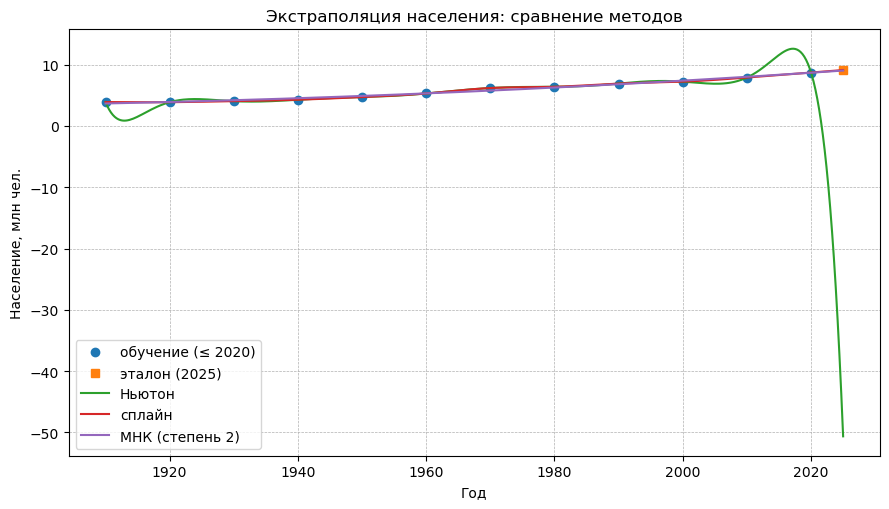

In [16]:
grid_years = np.linspace(float(x_train.min()), float(year_target), 400)
grid_t = (grid_years - x_center) / scale

grid_newton = np.array([newton_value(t_train, aN, tq) for tq in grid_t])
grid_spline = np.array([spline_eval_natural(x_train, y_train, M_nat, yr) for yr in grid_years])

best_coeffs = best_ls["коэфф"]
grid_ls = np.array([poly_eval_horner(best_coeffs, tq) for tq in grid_t])

plt.figure(figsize=(9.0, 5.2))
plt.plot(x_train, y_train / 1e6, "o", label="обучение (≤ 2020)")
plt.plot([year_target], [y_ref / 1e6], "s", label="эталон (2025)")

plt.plot(grid_years, grid_newton / 1e6, label="Ньютон")
plt.plot(grid_years, grid_spline / 1e6, label="сплайн")
plt.plot(grid_years, grid_ls / 1e6, label=f"МНК (степень {best_deg})")

plt.xlabel("Год")
plt.ylabel("Население, млн чел.")
plt.title("Экстраполяция населения: сравнение методов")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

## Короткое обсуждение

- **Ньютон (интерполяция)** проходит через все точки, но при экстраполяции может вести себя нестабильно (особенно на больших степенях).
- **Натуральный сплайн** обычно ведёт себя “гладко” и не даёт резких скачков между узлами; при экстраполяции мы используем крайний кубический участок.
- **МНК** не обязан проходить через все точки: он сглаживает шум, и за счёт подбора степени можно добиться более адекватного поведения при экстраполяции.

На практике для прогноза “вперёд” часто лучше работают сглаживающие модели (МНК) или сплайны, чем интерполяция высоким полиномом.